In [1]:
from fastai import *

%matplotlib inline

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz

In [3]:
%%bash
mkdir ../data/mnist
mv ../data/mnist.pkl.gz ../data/mnist/

In [4]:
path = Path('../data/mnist')
path.ls()

[PosixPath('../data/mnist/mnist.pkl.gz')]

In [5]:
with gzip.open(path / 'mnist.pkl.gz', 'rb') as f:
    train_data, valid_data, _ = pickle.load(f, encoding='latin-1')
x_train, y_train = train_data
x_valid, y_valid = valid_data
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

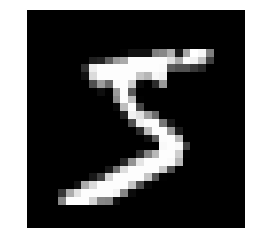

In [8]:
# Reshape to plot a sample
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
plt.axis('off');

In [9]:
# Convert from numpy array to Tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor,
                                         (x_train, y_train,
                                          x_valid, y_valid)
                                        )
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [10]:
BS = 64
# TensorDataset creates a dataset object from numpy array
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=BS)

In [11]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [12]:
class Mnist_Logistic(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10, bias=True)

    def forward(self, x):
        return self.linear(x)

In [25]:
model = Mnist_Logistic().cuda()
model

Mnist_Logistic(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [26]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [27]:
[param.shape for param in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

$$\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                   = -x[class] + \log\left(\sum_j \exp(x[j])\right)$$

$$\text{loss}(x, class) = weight[class] \left(-x[class] + \log\left(\sum_j \exp(x[j])\right)\right)$$

In [28]:
lr = 2e-2

In [29]:
loss_func = nn.CrossEntropyLoss()

In [30]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    
    # weight decay
    w2 = 0.
    for p in model.parameters():
        w2 += (p ** 2).sum()
    
    # add to regular loss
    loss = loss_func(y_hat, y) + w2 * wd
    loss.backward()
    
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    
    return loss.item()

In [31]:
losses = [update(x, y, lr) for x, y in data.train_dl]

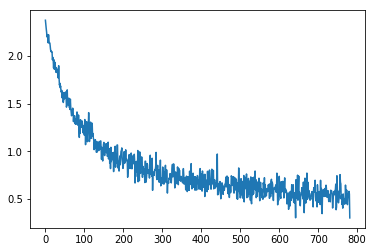

In [32]:
plt.plot(losses);

In [33]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

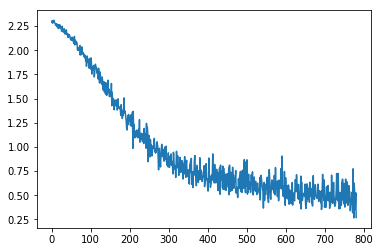

In [34]:
model = Mnist_NN().cuda()
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses);

In [35]:
model = Mnist_NN().cuda()

In [36]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

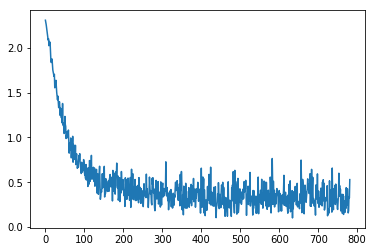

In [37]:
losses = [update(x,y,0.001) for x,y in data.train_dl]
plt.plot(losses);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


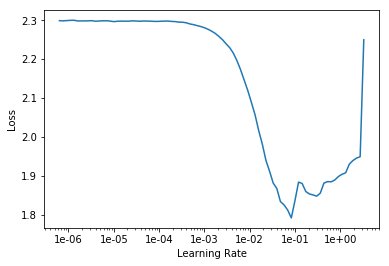

In [38]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func)
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(1, 1e-2)

Total time: 00:03
epoch  train_loss  valid_loss
1      0.147912    0.128255    (00:03)



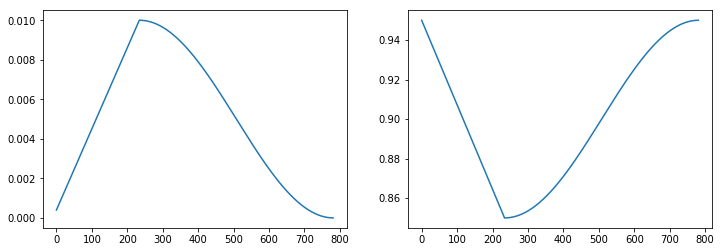

In [40]:
learn.recorder.plot_lr(show_moms=True)

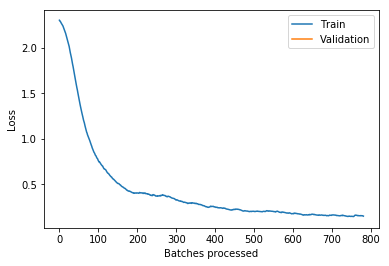

In [41]:
learn.recorder.plot_losses()

In [42]:
1 / 0.05, 1 / 0.15

(20.0, 6.666666666666667)